In [53]:
from chartpeer.loader import load
from chartpeer.analysis import *

# load bitcoin daily data (1440 minutes = 24h interval)
data = load.closedFromFile('C:\\Users\\weezl\\Desktop\\B0-B\\Scripting\\chartPeer-trading\\ChartPeer-SDK\\data\\XBTUSD_1440.csv')

# get 365 recent days of bitcoin closed prices
fade = 280
yearDataset = data[-365-fade:-fade]

# split the the year in 11 months and one additional "continuation" month
# this helps to compare the prediction to real data
testSet = yearDataset[:335]
continuation = yearDataset[335:365]

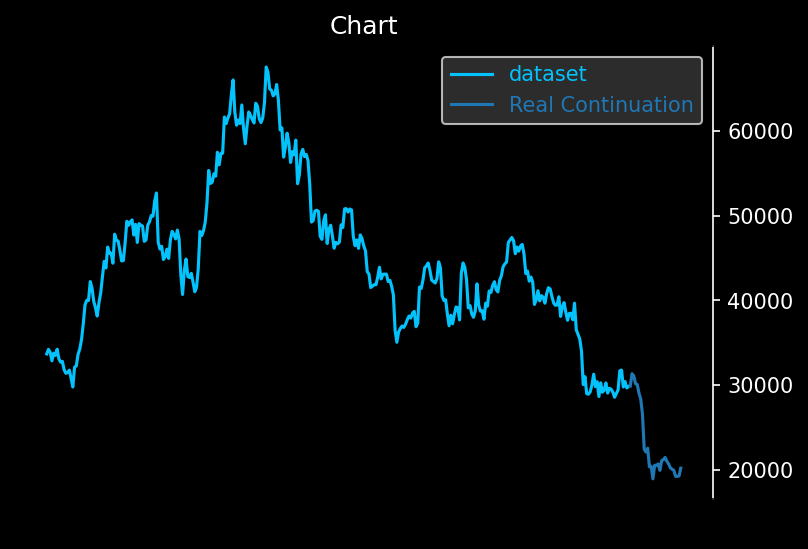

In [34]:
# plot the result for comparison
# plot the result for comparison
plot.chart(testSet, predictionSets = {
    'Real Continuation': continuation,
})

In [23]:
import numpy as np
import chartpeer.extrapolate as extrapolate

def gbm (data, length):

    '''
    Simulation of geometric brownian motion path.
    Drift mu and volatility sigma are sampled from the data.
    The standard error deviation on both parameters is 1/sqrt(N)
    i.e. 100 data points yield 1/10 uncertainty.
    '''

    mu = statistics.drift(data)
    sigma = statistics.volatility(data)

    S = [data[-1]]
    for t in range(length):
        delta_S = S[-1] * (mu + sigma * np.random.normal(0,1))
        S_new = S[-1] + delta_S
        S.append(S_new)
    
    return np.array(S[1:])


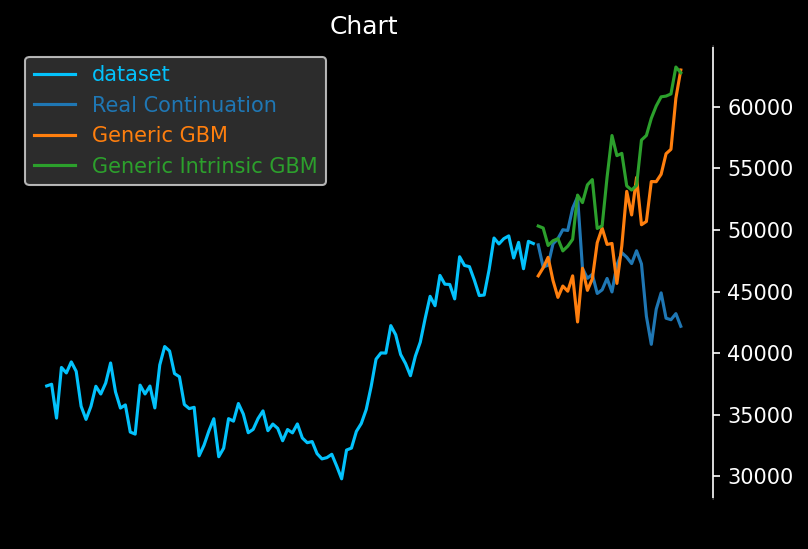

In [28]:
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Generic GBM': gbm(testSet, 30),
    'Generic Intrinsic GBM': extrapolate.gbm(testSet, 30, sampling='intrinsic')
})

# Model the VIX

Try to extract the timeresolved volatility from the underlying data

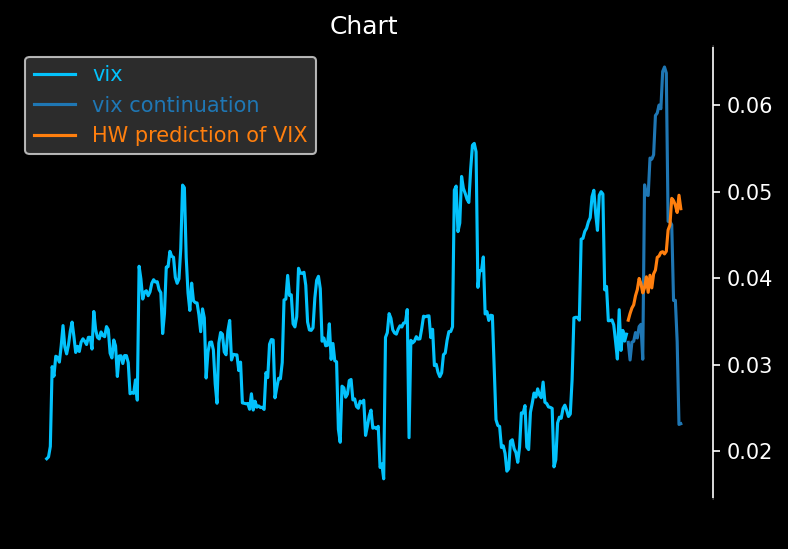

In [36]:
def vix (dataset, N):

    '''
    Volatility Index.
    Returns time-resolved volatility with window meaning N. 
    Meaning is obtained from simple moving average.
    '''

    vol = []
    for i in range(N, len(dataset)):
        slicedSet = np.array(dataset[i-N:i])
        v = statistics.volatility(slicedSet)
        vol.append(v)
    
    return np.array(vol)

v = vix(yearDataset, 14)

# split volatility array into input and target array
v_input = v[:-30]
v_target = v[-30:]

from chartpeer.extrapolate import hw
from chartpeer.extrapolate import hw_fit

# fit smoothing parameters by providing demanded extrapolation size and period 
# this can take a couple of seconds.
fit = hw_fit(v_input, 30, periodInIntervals=7, fitRange=[0,1])

# inject fit into new prediction
prediction_auto = hw(v_input, 30, *fit, periodInIntervals=30)

plot.chart(v_input, name='vix', predictionSets={
    'vix continuation': v_target,
    'HW prediction of VIX': prediction_auto
})

In [37]:
# second idea is to model the vix with lstm

from chartpeer.extrapolate import lstm

predictor = lstm(sequence_length=60, feature_length=30, epochs=10, batch_size=1)

vix_prediction = predictor.predict(v_input)['prediction']

Epoch 1/10
231/231 [==============================] - 6s 16ms/step - loss: 0.0599
Epoch 2/10
231/231 [==============================] - 4s 16ms/step - loss: 0.0407
Epoch 3/10
231/231 [==============================] - 4s 16ms/step - loss: 0.0349
Epoch 4/10
231/231 [==============================] - 4s 16ms/step - loss: 0.0328
Epoch 5/10
231/231 [==============================] - 4s 17ms/step - loss: 0.0291
Epoch 6/10
231/231 [==============================] - 4s 16ms/step - loss: 0.0281
Epoch 7/10
231/231 [==============================] - 4s 16ms/step - loss: 0.0263
Epoch 8/10
231/231 [==============================] - 4s 16ms/step - loss: 0.0218
Epoch 9/10
231/231 [==============================] - 4s 16ms/step - loss: 0.0224
Epoch 10/10
1/1 [==============================] - 0s 479ms/step


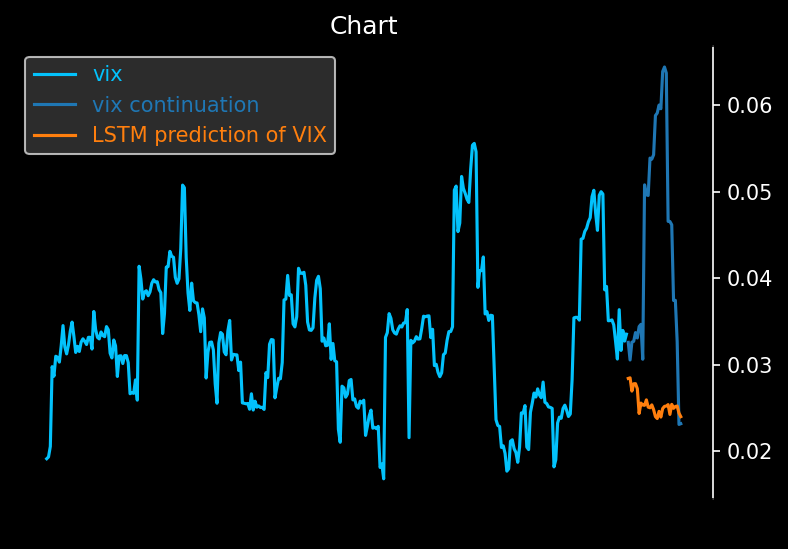

In [38]:
plot.chart(v_input, name='vix', predictionSets={
    'vix continuation': v_target,
    'LSTM prediction of VIX': vix_prediction
})

LSTM for VIX prediction seems most suitable as LSTM is able to detect even slightest patterns and converges almost always - the higher the mean window, the better the convergence will be due to the smoothness. In general better results are achieved with smaller batch size (ideally single batch i.e. 1) and larger epochs. Good results were observed with 20 epochs and batch_size=1 for a 60->30 length prediction.

# Model the Drift

Epoch 1/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0299
Epoch 2/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0279
Epoch 3/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0260
Epoch 4/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0256
Epoch 5/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0255
Epoch 6/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0237
Epoch 7/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0223
Epoch 8/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0216
Epoch 9/10
235/235 [==============================] - 4s 16ms/step - loss: 0.0200
Epoch 10/10
1/1 [==============================] - 0s 18ms/step


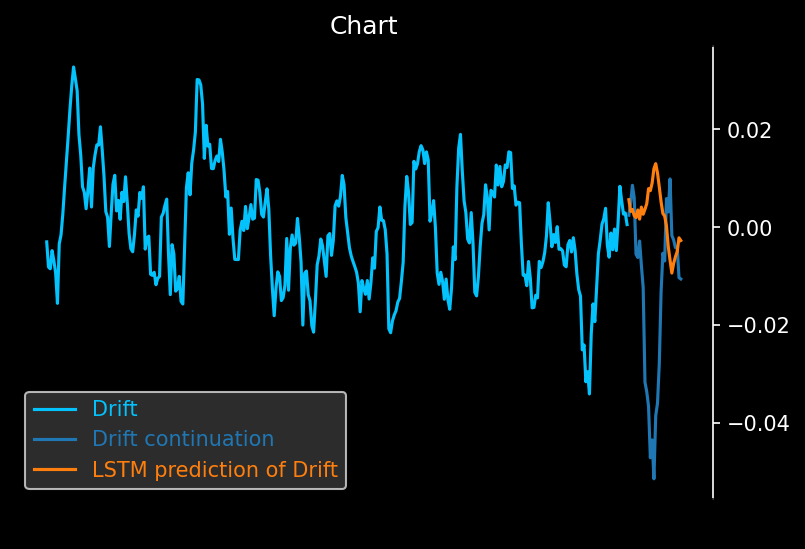

In [39]:
# analgogously resolve the drift over time

def driftHistory (dataset, N):
    d = []
    for i in range(N, len(dataset)):
        drf = statistics.drift(np.array(dataset[i-N:i]))
        d.append(drf)
    return np.array(d)

d = driftHistory(yearDataset, 10)
d_input = d[:-30]
d_target = d[-30:]

#predictor = lstm(sequence_length=60, feature_length=30, epochs=30, batch_size=10)
drift_prediction = predictor.predict(d_input)['prediction']

plot.chart(d_input, name='Drift', predictionSets={
    'Drift continuation': d_target,
    'LSTM prediction of Drift': drift_prediction
})

# Extended GBM

An obvious flaw of the geometric brownian motion SDE is that the drift and volatility are assumed to be constant. For a better fit we will assume the parameters $\mu$ and $\sigma$ to evolve according to the LSTM fits.

In [40]:
def gbm_ext (data, length):

    '''
    Simulation of geometric brownian motion path.
    Drift mu and volatility sigma vary over time are taken from LSTM fit.
    The differential equation is fixed accordingly.
    '''

    mu = drift_prediction
    sigma = vix_prediction

    S = [data[-1]]
    for t in range(length):
        delta_S = S[-1] * (mu[t] + sigma[t] * np.random.normal(0,1))
        S_new = S[-1] + delta_S
        S.append(S_new)
    
    return np.array(S[1:])

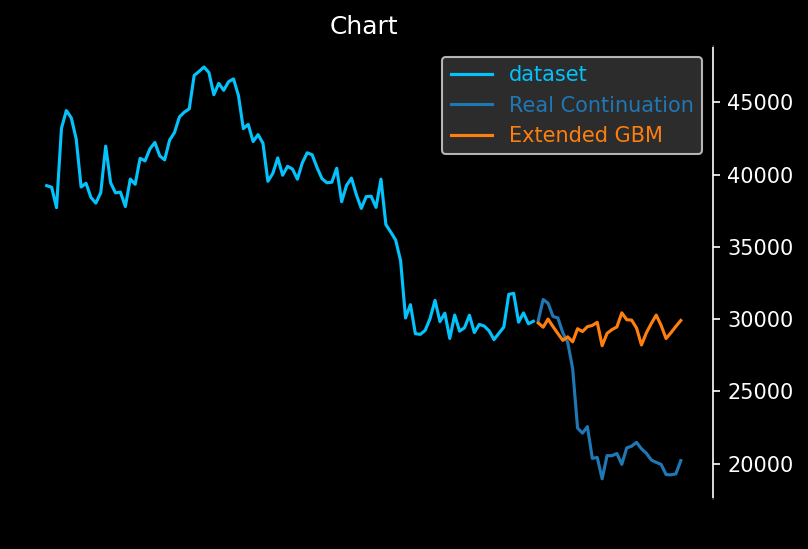

In [50]:
plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Extended GBM': gbm_ext(testSet, 30)
})

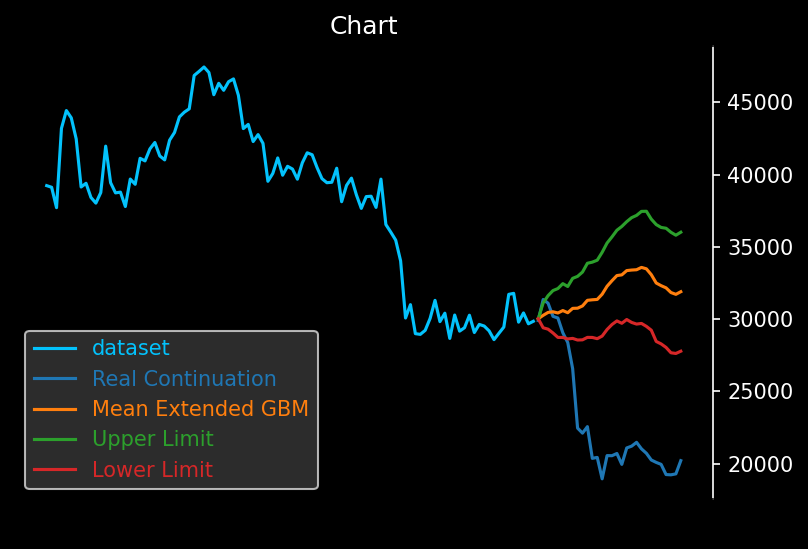

In [51]:
# try to plot a meaned set of MC generations
generations = 30
g = gbm_ext(testSet, 30)
for i in range(generations-1):
    g = g + gbm_ext(testSet, 30)

g = g / generations

# define limits by the vix
dev = 1
upper_lim = []
lower_lim = []
for i in range(len(vix_prediction)):
    upper_lim.append(g[i]*(1+dev*vix_prediction[i]*np.sqrt(i)))
    lower_lim.append(g[i]*(1-dev*vix_prediction[i]*np.sqrt(i)))
upper_lim = np.array(upper_lim)
lower_lim = np.array(lower_lim)

plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Mean Extended GBM': g,
    'Upper Limit': upper_lim,
    'Lower Limit': lower_lim
})

# New Model for Geometric Brownian SDE

Most extensions of the GBM SDE are based on a stochastic volatility model, where the volatility is not constant but instead follows a geometric brownian itself. To focus on the general ansatz the SDE can be extended to 

\begin{align*}
dS_t = \mu S_t + \nu_t S_t dW_t
\end{align*}

where $\nu_t$ denotes the time-dependent volatility. At this level of generalization the following thesis is raised, whether the drift $\mu$ can vary as well. Indeed such approaches exist - within the reasearch field of <strong>stochastic volatility</strong>. The time dependence of GBM parameters relies on the pragmatic idea to apply the same modelling on generator level, where the combination of $\mu$ and $\sigma$ acts as the generating moment $\frac{d S}{d t}$ and can be calculated with Itô's general solution.

Assuming that the vectors $\nu(t) \equiv \nu_t$ and $\mu(t)$ could be approximated accurately enough (at least in the mean), it would increase the sampling efficiency due to better price direction sampling and also would make methods like selection of specific path generations (which suite the conjectured continuation from other methods) obsolete. Also the time-resolved volatility allows to model uncertainty regimes over time.

Further the model can also be extended by a self-study ansatz "intrinsic geometric brownian motion", which exploits the method of sampling from an intrinsic log return distribution accounted from data instead of sampling from a standard normal. When the expected mean drift $\mu=\left\langle log \left (  R \right ) \right\rangle_a$ is subtracted from the distribution and devided by the meaned volatility $\sigma$ then the obtained distribution should be "similar" to a standard normal distribution $\sim \mathcal{N}(0,1)$ and thus an unbiased estimator. The assumption that the mean is zero arises from the central limit theorem, and is actually biased by the standard error $1/\sqrt(n)$, so for a large enough data sample the bias should converge sufficiently to zero. The newly derived distribution yields the "sampled wiener distribution" which can be exploited for better (less-biased) sampling of randomness. This will allow to model specific return patterns realistically, since specific returns which were not obsereved in data cannot be sampled for the future, while a gaussian simply assumes a smooth non-zero value and underestimates edge-tail events, which are non-negligible. Increments obtained (sampled) from the sampled wiener distribution are denoted by $d\tilde{W}_t$. The newly improved differential equation can be written as


\begin{align*}
dS_t = \mu_t S_t + \nu_t S_t d\tilde{W}_t
\end{align*}

How are the parameters approximated?

Epoch 1/20
215/215 [==============================] - 5s 15ms/step - loss: 0.0163
Epoch 2/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0118
Epoch 3/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0101
Epoch 4/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0094
Epoch 5/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0090
Epoch 6/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0091
Epoch 7/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0086
Epoch 8/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0083
Epoch 9/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0084
Epoch 10/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0081
Epoch 11/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0085
Epoch 12/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0082
Epoch 13/20
2

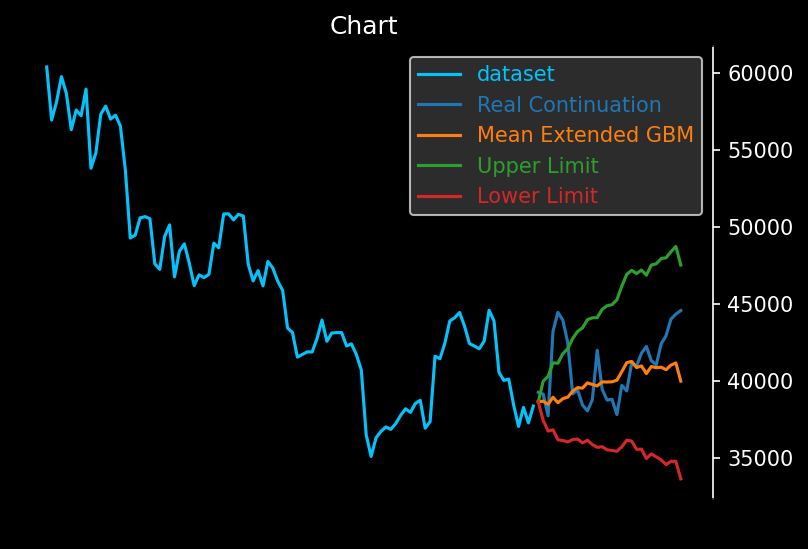

In [56]:
from chartpeer.extrapolate import lstm

def lstm_gbm (dataset, feature_length, generations=10, smoothing=14, 
              epochs=(20, 1), batch_size=1, input_size=60, deviation=1):

    '''
    LSTM sustained Geometric Brownian Motion Algorithm.
    Estimator is determined through Monte Carlo Simulation of 
    extended GBM SDE 

        dS(t) = S(t-1) * (mu(t) + sigma[t] * np.random.normal(0,1))
    
    with 1/sqrt(generations) uncertainty of the mean convergence and
    1/sqrt(t) uncertainty growth over time. 
    Time evolution of volatility and drift are fitted with a RNN.

    Parameters:
    -----------
    dataset             1D array of closed prices 
                        (if list was provided it will be converted to np.ndarray)
    feature_length      Extrapolation length - will be applied to each MC generation 
                        of length "feature_length" which will be meaned to a vector.
    generations         Number of Monte Carlo generations. Larger values will converge
                        closer to expected mean due to smaller standard error 1/sqrt(generations),
                        but also volatility contributions will be smoothened out.
    smoothing           Smoothing window for volatility and drift screening.
    epochs              Tuple of epochs (epochs for volatility training, for drift training).
                        The second element is usually smaller since drift training will used 
                        pre-trained model from VIX prediction.
    batch_size          Size of input-output tuples to propagate at once - higher batch times save time
                        but during training converge in a more smooth way which fits multiple generations.
                        Highest accuracy was observed with mini-batch training i. e. with batch_size=1. 
    input_size          The neural input size at which input slices should be sampled and 
                        propagated during training - the number of values from which the extra values
                        should be estimated. This parameter might influence the efficiency,
                        but scales with the backpropagation time.

    Return:
    -------
    Dict object with with keys mean, upper (bound), lower (bound) and their respective 1D arrays.
    '''

    # convert to numpy array if list was provided
    if type(dataset) is list:
        dataset = np.array(dataset)



    # compute the volatility index by accounting volatilites across a window span
    # and simple average it, save into a numpy array
    vol = []
    for i in range(smoothing, len(dataset)):
        slicedSet = np.array(dataset[i-smoothing:i])
        v = statistics.volatility(slicedSet)
        vol.append(v)
    vix = np.array(vol)

    # init lstm prediction
    predictor = lstm(sequence_length=input_size, feature_length=feature_length, epochs=epochs[0], batch_size=batch_size)
    vix_prediction = predictor.predict(vix)['prediction']

    # repeat the whole process for the drift resolvement
    # take the pre-trained lstm predictor and fit to drift 
    drifts = [] # array for moving avg. of the drift
    for i in range(smoothing, len(dataset)):
        drifts.append(statistics.drift(np.array(dataset[i-smoothing:i])))
    drift_prediction = predictor.predict(drifts, epochs=epochs[1])['prediction']



    # construct the intrinsic cummulated probability distribution from
    # the set of logarithmic returns. From each log return subtract the 
    # expected drift and devide by the standard deviation (sampled drift and volatility)
    # to obtain the intrinsic wiener probability distribution, this will be similar but 
    # different from a standard normal distribution.  
    returnIncrement = 0.0001
    logReturns = []
    for i in range(len(dataset)-1):
        logReturns.append(np.log(dataset[i+1]/dataset[i]))
    
    # convert log-returns to standard normal values.
    # At this step the characteristic wiener process i.e.
    # the origin distribution is modelled, by subtracting and deviding
    # geometric brownian expectation values.
    logReturns = np.array(logReturns)
    mu = np.mean(logReturns)
    sigma = np.std(logReturns)
    logReturns = logReturns - mu
    logReturns = logReturns / sigma

    # count occurrences for likelihoods+,
     
    start, stop = np.min(logReturns), np.max(logReturns)
    returnRange = stop - start
    bins = int(returnRange/returnIncrement) + 1
    returnSpace = np.linspace(start, stop, bins)
    likelihood = np.zeros((bins,))
    for r in logReturns:
        for pointer in range(bins-1):
            if r < returnSpace[pointer+1] and r > returnSpace[pointer]:
                likelihood[pointer] = likelihood[pointer] + 1
                break
    N = len(logReturns)
    likelihood = [val/N for val in likelihood]  # normalize

    # build cummulative distribution function
    cummulativeDistribution = [likelihood[0]]
    for i in range(1, len(likelihood)):
        cummulativeDistribution.append(cummulativeDistribution[-1]+likelihood[i])



    # Simulation of geometric brownian motion path.
    # Drift mu and volatility sigma vary over time and are taken from LSTM fit.
    # The differential equation is fixed accordingly.
    mu = drift_prediction
    sigma = vix_prediction

    
    generationSet = []

    for g in range(generations):

        # start new generation
        S = [dataset[-1]]

        # generate a sequence of wiener values from intrinsic distribution
        # using an inverse sampling method from the inverse of the cummulative distribution
        dW = []
        for _ in range(feature_length):    
            u = np.random.uniform(0,1)
            r = 0
            for i in range(len(cummulativeDistribution)):
                if u < cummulativeDistribution[i]:
                    r = returnSpace[i]
                    break  
            dW.append(r)         
        for t in range(feature_length):

            # improved stochastic differential equation with variable drift and volatility.
            # The wiener increment dW originates from the extracted intrinsic distribution.
            delta_S = S[-1] * (mu[t] + sigma[t] * dW[t])
            
            S_new = S[-1] + delta_S
            S.append(S_new)

        generationSet.append(np.array(S[1:]))

    # convert generation set to array
    generationSet = np.array(generationSet)

    # mean estimate
    g = np.mean(generationSet, axis=0)

    # compute the bounds
    # define limits by the vix
    upper_lim = []
    lower_lim = []
    for i in range(len(vix_prediction)):
        uncertainty = np.sqrt(i)
        upper_lim.append(g[i]*np.exp(deviation * vix_prediction[i] * uncertainty))
        lower_lim.append(g[i]*np.exp(-deviation * vix_prediction[i] * uncertainty))
    upper_lim = np.array(upper_lim)
    lower_lim = np.array(lower_lim)
    
    return {
        'mean': g,
        'upper': upper_lim,
        'lower': lower_lim
    }

output = lstm_gbm(testSet, 30, epochs=(20,10), smoothing=5)

plot.chart(testSet[-100:], predictionSets = {
    'Real Continuation': continuation,
    'Mean Extended GBM': output['mean'],
    'Upper Limit': output['upper'],
    'Lower Limit': output['lower']
})